In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49573501 entries, 0 to 49573500
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   CUSTOMER_NUMBER            object
 1   ENTERPRISE_ACCOUNT_NO      object
 2   ENTERPRISE_ACCOUNT_NAME    object
 3   NATIONAL_ACCOUNT           object
 4   PAYER                      object
 5   DOCUMENT_DATE_IN_DOCUMENT  dbdate
 6   DOCUMENT_TYPE              object
 7   POSTING_KEY_NAME           object
 8   AMOUNT_IN_LOCAL_CURRENCY   object
 9   CREDIT_CONTROL_AREA        object
 10  AR_STATUS                  object
 11  PAYMENT_DATE               dbdate
 12  CC_DAYS_TO_ADD             object
dtypes: dbdate(2), object(11)
memory usage: 4.8+ GB


In [7]:
# df['PAYMENT_DATE']=pd.to_datetime(df['PAYMENT_DATE'])
# df.query('"2024-01-01" >=PAYMENT_DATE')

In [8]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df.reset_index(inplace = True)


In [9]:
def calc_WAPD(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= PAYMENT_DATE >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [10]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [68]:
def search_EAN(ENTERPRISE_ACCOUNT_NO):
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
    
#     loop for terms 

    four = CUSTOMER_df.query('CC_DAYS_TO_ADD ==4.000000000')
    thirty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==30.000000000')
    sixty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==60.000000000')
    ninty = CUSTOMER_df.query('CC_DAYS_TO_ADD ==90.000000000')








# FOUR



    four['AMOUNT_IN_LOCAL_CURRENCY']=four['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    four['Sub Payment Date from Invoice Date']=(four['PAYMENT_DATE']-four['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    four['Weighted Invoice Value']= four['Sub Payment Date from Invoice Date']*four['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(four['PAYMENT_DATE'])
    four['90_days_ago']= current - pd.to_timedelta('90 days')
    four = calc_WAPD(four)
    
#   THIRTY  
    
    thirty['AMOUNT_IN_LOCAL_CURRENCY']=thirty['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    thirty['Sub Payment Date from Invoice Date']=(thirty['PAYMENT_DATE']-thirty['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    thirty['Weighted Invoice Value']= thirty['Sub Payment Date from Invoice Date']*thirty['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(thirty['PAYMENT_DATE'])
    thirty['90_days_ago']= current - pd.to_timedelta('90 days')
    thirty = calc_WAPD(thirty)
    
    
    
    
    return four, thirty, sixty, ninty 

In [12]:
def search_NAT(NATIONAL_ACCOUNT):
    None

# **********************************************************************************************************

# Visualization

## Customer

In [13]:
customer = "2057194397"
t = search_customer(customer)

In [14]:
t

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,Sub Payment Date from Invoice Date,WAPD,Weighted Invoice Value,90_days_ago
0,1757218,3590035,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-05,ZF,01 - Invoice,716.6300,PD,CLEAR,2022-09-02,28.000000000,28,30.6143,20065.6400,2022-06-04
1,1776206,3611111,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,28.7100,PD,CLEAR,2022-09-02,28.000000000,30,30.6143,861.3000,2022-06-04
2,1779784,3615044,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-02,ZF,01 - Invoice,2676.5900,PD,CLEAR,2022-09-02,28.000000000,31,30.6143,82974.2900,2022-06-04
3,1781469,3616908,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-04,ZF,01 - Invoice,38.5000,PD,CLEAR,2022-09-02,28.000000000,29,30.6143,1116.5000,2022-06-04
4,1804270,3642218,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2022-08-03,ZF,01 - Invoice,506.9700,PD,CLEAR,2022-09-02,28.000000000,30,30.6143,15209.1000,2022-06-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,41646621,49495596,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-18,ZF,01 - Invoice,1599.7000,PD,CLEAR,2023-09-15,28.000000000,28,26.9437,44791.6000,2023-06-17
562,41650622,49499870,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-18,ZF,01 - Invoice,2681.7600,PD,CLEAR,2023-09-15,28.000000000,28,26.9437,75089.2800,2023-06-17
563,41655350,49504940,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-15,ZF,01 - Invoice,751.1000,PD,CLEAR,2023-09-15,28.000000000,31,26.9437,23284.1000,2023-06-17
564,41666227,49516656,2057194397,7100004137,7100004137 - CONVERSIO HEALTH,0000000101,2057194397,2023-08-17,ZF,01 - Invoice,1818.1700,PD,CLEAR,2023-09-15,28.000000000,29,26.9437,52726.9300,2023-06-17


In [15]:
t['month'] = t['PAYMENT_DATE'].dt.strftime('%b')

In [16]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp1 = pd.pivot_table(data=t, index=[t.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp1 = dfp1.reindex(year_order, axis=1)

In [17]:
dfp1

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.2435,29.8647,29.9069,29.9826
2023,30.0828,29.5841,27.5906,24.8068,24.9288,24.9342,26.1582,25.3285,26.6899,NaN,NaN,NaN


In [ ]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# dfp = pd.pivot_table(data=CONVERSIO_HEALTH_df, index=[CONVERSIO_HEALTH_df.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
# dfp = dfp.reindex(year_order, axis=1)
# dfp

In [ ]:
# ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
# _ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

In [69]:
EAN = "7100000391"
four, thirty,_,_ = search_EAN(EAN)

In [70]:
four

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,Sub Payment Date from Invoice Date,WAPD,Weighted Invoice Value,90_days_ago
0,65587,1527800,2057194153,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057194153,2022-08-01,ZF,01 - Invoice,71.6600,PD,CLEAR,2022-08-09,4.000000000,8,5.6385,573.2800,2022-05-11
1,65588,1527801,2057194425,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057194425,2022-08-01,ZF,01 - Invoice,2533.9100,PD,CLEAR,2022-08-09,4.000000000,8,5.6385,20271.2800,2022-05-11
2,65615,1527873,2057207395,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057207395,2022-08-04,ZF,01 - Invoice,345.4500,PD,CLEAR,2022-08-09,4.000000000,5,5.6385,1727.2500,2022-05-11
3,65686,1528103,2057194151,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057194151,2022-08-04,ZF,01 - Invoice,2809.7000,PD,CLEAR,2022-08-09,4.000000000,5,5.6385,14048.5000,2022-05-11
4,65689,1528106,2057194153,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057194153,2022-08-01,ZF,01 - Invoice,99.0000,PD,CLEAR,2022-08-09,4.000000000,8,5.6385,792.0000,2022-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64101,40976213,48730674,2057208043,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057208043,2023-08-02,ZF,01 - Invoice,7.4800,PD,CLEAR,2023-09-08,4.000000000,37,30.4537,276.7600,2023-06-10
64102,40976214,48730675,2057208044,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057208044,2023-08-02,ZF,01 - Invoice,1878.8800,PD,CLEAR,2023-09-08,4.000000000,37,30.4537,69518.5600,2023-06-10
64103,40976215,48730676,2057208047,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057208047,2023-08-05,ZF,01 - Invoice,653.3300,PD,CLEAR,2023-09-08,4.000000000,34,30.4537,22213.2200,2023-06-10
64104,40977033,48731560,2057208044,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000011179,2057208044,2023-08-03,ZF,01 - Invoice,3151.7500,PD,CLEAR,2023-09-08,4.000000000,36,30.4537,113463.0000,2023-06-10


In [77]:
four['month'] = four['PAYMENT_DATE'].dt.strftime('%b')
thirty['month'] = thirty['PAYMENT_DATE'].dt.strftime('%b')

In [72]:
# four = s.query('CC_DAYS_TO_ADD ==4.000000000')
# thirty =s.query('CC_DAYS_TO_ADD ==30.000000000')
# sixty =s.query('CC_DAYS_TO_ADD ==60.000000000')
# ninty = s.query('CC_DAYS_TO_ADD ==90.000000000')

In [73]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=four, index=[four.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)
dfp

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6671,5.9355,6.1530,6.4311,9.1430
2023,10.8311,10.5710,6.0590,4.7303,6.6613,16.3634,21.5822,25.9741,30.4537,NaN,NaN,NaN


In [74]:
four.CC_DAYS_TO_ADD.unique()

array([Decimal('4.000000000')], dtype=object)

In [75]:
s.query('CC_DAYS_TO_ADD ==90.000000000 or CC_DAYS_TO_ADD ==30.000000000 or CC_DAYS_TO_ADD ==60.000000000')

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,Sub Payment Date from Invoice Date,WAPD,Weighted Invoice Value,90_days_ago,month
7467,3090903,5132735,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-08,ZF,01 - Invoice,6770.6000,SPD,CLEAR,2022-09-15,30.000000000,38,5.8954,257282.8000,2022-06-17,Sep
10154,4459339,6698645,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-03,ZF,01 - Invoice,56997.3800,SPD,CLEAR,2022-09-29,30.000000000,57,6.3865,3248850.6600,2022-07-01,Sep
10155,4468098,6708422,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-23,ZF,01 - Invoice,379.4800,SPD,CLEAR,2022-09-29,30.000000000,37,6.3865,14040.7600,2022-07-01,Sep
10156,4470957,6711612,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-04,ZF,01 - Invoice,3046.9800,SPD,CLEAR,2022-09-29,30.000000000,56,6.3865,170630.8800,2022-07-01,Sep
10157,4472904,6713856,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-02,ZF,01 - Invoice,3886.8800,SPD,CLEAR,2022-09-29,30.000000000,58,6.3865,225439.0400,2022-07-01,Sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63748,40872151,48617061,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-16,ZF,01 - Invoice,28.0000,SPD,CLEAR,2023-09-08,30.000000000,23,32.4866,644.0000,2023-06-10,Sep
63759,40873226,48618255,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-11,ZF,01 - Invoice,2739.2400,SPD,CLEAR,2023-09-08,30.000000000,28,32.4866,76698.7200,2023-06-10,Sep
63817,40886598,48632883,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-11,ZF,01 - Invoice,190122.8200,SPD,CLEAR,2023-09-08,30.000000000,28,32.4866,5323438.9600,2023-06-10,Sep
63882,40898316,48645703,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-15,ZF,01 - Invoice,86152.8100,SPD,CLEAR,2023-09-08,30.000000000,24,32.4866,2067667.4400,2023-06-10,Sep


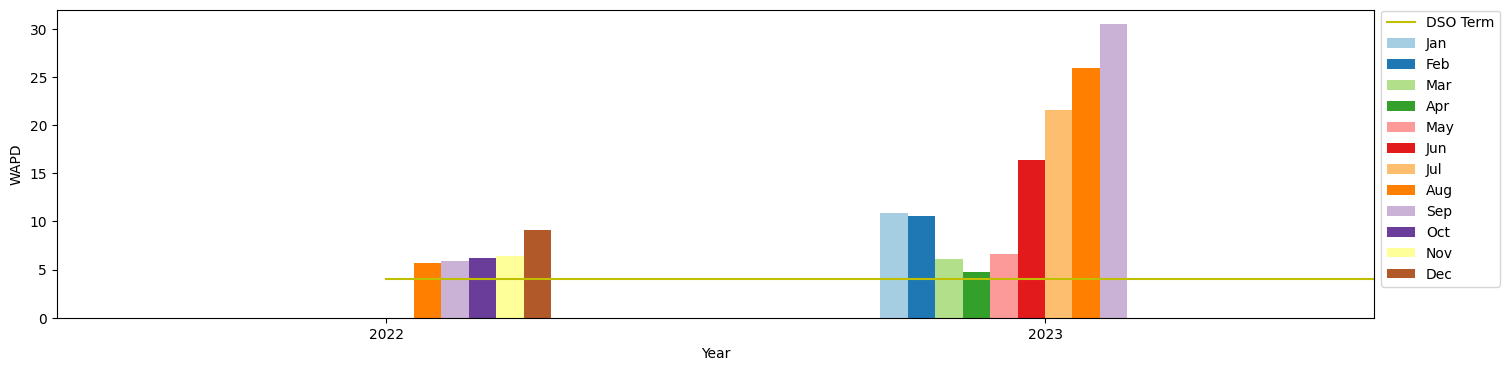

In [76]:
ax = dfp.plot(kind='bar', figsize=(17, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(four.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [84]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_thirty = pd.pivot_table(data=thirty, index=[thirty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_thirty = dfp_thirty.reindex(year_order, axis=1)
dfp_thirty

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.7802,51.5348,47.1176,49.0126
2023,50.7768,59.1402,60.8968,56.1709,54.9780,43.9196,45.3093,43.5584,41.7740,NaN,NaN,NaN


In [85]:
thirty

,level_0,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,Sub Payment Date from Invoice Date,WAPD,Weighted Invoice Value,90_days_ago,month
7467,3090903,5132735,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-08,ZF,01 - Invoice,6770.6000,SPD,CLEAR,2022-09-15,30.000000000,38,38.0000,257282.8000,2022-06-17,Sep
10154,4459339,6698645,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-03,ZF,01 - Invoice,56997.3800,SPD,CLEAR,2022-09-29,30.000000000,57,55.3582,3248850.6600,2022-07-01,Sep
10155,4468098,6708422,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-23,ZF,01 - Invoice,379.4800,SPD,CLEAR,2022-09-29,30.000000000,37,55.3582,14040.7600,2022-07-01,Sep
10156,4470957,6711612,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-04,ZF,01 - Invoice,3046.9800,SPD,CLEAR,2022-09-29,30.000000000,56,55.3582,170630.8800,2022-07-01,Sep
10157,4472904,6713856,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-08-02,ZF,01 - Invoice,3886.8800,SPD,CLEAR,2022-09-29,30.000000000,58,55.3582,225439.0400,2022-07-01,Sep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63748,40872151,48617061,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-16,ZF,01 - Invoice,28.0000,SPD,CLEAR,2023-09-08,30.000000000,23,41.7740,644.0000,2023-06-10,Sep
63759,40873226,48618255,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-11,ZF,01 - Invoice,2739.2400,SPD,CLEAR,2023-09-08,30.000000000,28,41.7740,76698.7200,2023-06-10,Sep
63817,40886598,48632883,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-11,ZF,01 - Invoice,190122.8200,SPD,CLEAR,2023-09-08,30.000000000,28,41.7740,5323438.9600,2023-06-10,Sep
63882,40898316,48645703,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2023-08-15,ZF,01 - Invoice,86152.8100,SPD,CLEAR,2023-09-08,30.000000000,24,41.7740,2067667.4400,2023-06-10,Sep


In [94]:
thirty.CC_DAYS_TO_ADD.unique()

array([Decimal('30.000000000')], dtype=object)

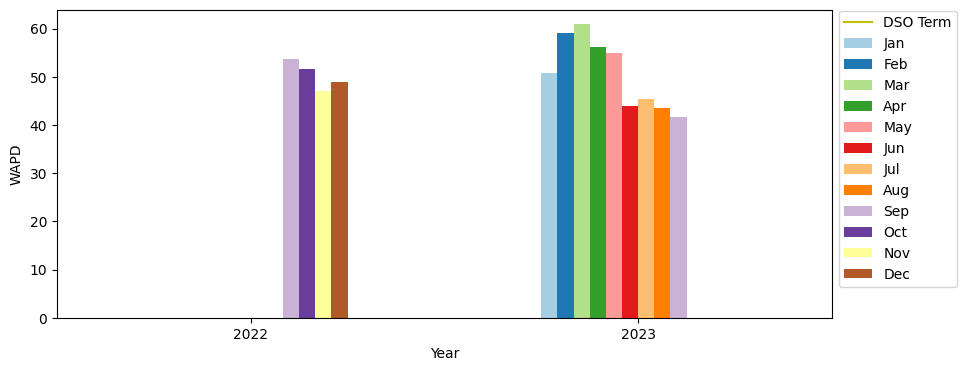

In [96]:
ax = dfp_thirty.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(thirty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## National Account